# Biases in Pretrained Embeddings

In this notebook, we'll attempt to build a sentiment classifier, first using pretrained word embeddings (GloVe) and then next using BERT (from Week 7's workshop), and see if these pretrained embeddings/models inherently contain any biases.

What is GloVe embeddings? They are word embeddings like Word2Vec, but implemented differently. If you're interested to read more about GloVe, you can find more information [here](https://nlp.stanford.edu/projects/glove/). The crucial thing to note here is that GloVe embeddings are trained on Google News and Common Crawl web data, and so the embeddings themselves are likely to capture common stereotypes and biases in our culture.

First, let's upload the GloVe embeddings ("13-glove.6B.50d.txt") to your colab instance.

Refresher:

1. To upload files, click the folder icon on the left, and click the "upload" icon to choose files from your local drive (you can also drag and drop files to upload them). Once the files are uploaded, you should see them appearing in the file system.

2. Don't forget to enable GPU on the colab notebook. We can do this by going to "Runtime $>$ Change runtime type" and selecting "GPU" as the hardware accelerator. Click save.

Now let's get started. Let's load some libraries that we'll be using for building the first sentiment classifier using the GloVe embeddings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import re

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Next, we'll define a function to load the embeddings using the text file. The format is pretty self-explanatory if you view the embeddings file: it's just one line for each word.

Note: the loading process might take a couple seconds.

In [2]:
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

embeddings = load_embeddings('13-glove.6B.50d.txt')
print(embeddings.shape)

(400000, 50)


One way to build a sentiment classifier is to use a sentiment lexicon: a dictionary that contains positive and negative words. There are many sentiment lexicons you could use, but we'll be using the [Opinion Lexicon](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon). Download them (`13-positive-words.txt` and `13-negative-words.txt` from Canvas) and put them in the same directory of this notebook. Once that's done, we'll load the lexicon using the function defined below.

In [3]:
def load_lexicon(filename):
    """
    Load a file from Bing Liu's sentiment lexicon
    (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), containing
    English words in Latin-1 encoding.
    
    One file contains a list of positive words, and the other contains
    a list of negative words. The files contain comment lines starting
    with ';' and blank lines, which should be skipped.
    """
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

pos_words = load_lexicon('13-positive-words.txt')
neg_words = load_lexicon('13-negative-words.txt')

print(pos_words[:30])
print(neg_words[:30])

['a+', 'abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation', 'accolade', 'accolades', 'accommodative', 'accomodative', 'accomplish', 'accomplished', 'accomplishment', 'accomplishments', 'accurate', 'accurately', 'achievable', 'achievement', 'achievements', 'achievible', 'acumen', 'adaptable', 'adaptive', 'adequate', 'adjustable', 'admirable']
['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable', 'abominably', 'abominate', 'abomination', 'abort', 'aborted', 'aborts', 'abrade', 'abrasive', 'abrupt', 'abruptly', 'abscond', 'absence', 'absent-minded', 'absentee', 'absurd', 'absurdity', 'absurdly', 'absurdness', 'abuse', 'abused', 'abuses', 'abusive', 'abysmal', 'abysmally', 'abyss']


So how do we build a sentiment classifier using word embeddings? We'll take a very simple approach, where we embed the positive and negative words using GloVe embeddings, and then train a logistic regression model that predict their sentiments based on their embeddings. Once trained, we can then apply the logistic regression to all other words not part of the lexicon that have a corresponding GloVe embeddings to predict their sentiments.

Note: `index.intersection()` is used to only words that are in the GloVe vocabulary

In [4]:
pos_vectors = embeddings.loc[embeddings.index.intersection(pos_words)]
neg_vectors = embeddings.loc[embeddings.index.intersection(neg_words)]

pos_vectors.sort_index(inplace = True)
neg_vectors.sort_index(inplace = True)

pos_vectors

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
abound,0.680940,0.681610,-0.598430,0.452900,-0.695230,0.024194,-0.281520,-0.647090,-0.287200,0.339580,...,-0.272300,0.341360,0.526700,1.151500,0.907630,0.560140,0.360690,0.685340,0.223100,-0.926680
abounds,0.344170,0.401890,-0.801010,0.605540,-0.364730,-0.517050,0.318030,-0.310820,0.155790,1.076700,...,0.196530,0.335710,-0.115510,0.509530,0.152230,0.601010,0.450700,1.021500,0.450880,-0.938780
abundance,0.135060,1.014300,-0.550050,0.134170,0.714800,-0.061255,-0.110980,-0.482330,0.960090,0.797050,...,-0.160630,0.026046,-0.084491,0.280180,0.251620,0.048608,-0.006860,-0.006417,0.094202,-0.321800
abundant,0.372980,0.772570,-0.497300,0.272560,0.433190,-0.393870,-0.430560,-0.174180,1.267900,0.874630,...,-0.368700,0.025354,-0.152660,0.238080,0.404190,0.191850,-0.503270,0.048975,-0.080421,-0.523340
accessible,0.746860,0.710430,0.444680,-0.250280,-0.401760,-0.555660,-0.878610,-0.487020,0.800530,0.420210,...,0.641040,-0.499470,0.821910,0.969470,-0.729920,-0.031303,-0.210450,-0.544280,0.557920,-0.110500
acclaim,-0.592170,0.527210,-0.231590,-0.582410,-0.376310,-0.012175,-0.427890,0.071798,0.424590,2.103400,...,0.544190,0.077834,-1.140700,-0.617610,-1.097100,-0.010793,-0.619540,0.111450,-0.446600,-0.258610
acclaimed,-0.285720,0.444580,-0.745500,-0.376100,-0.317760,0.290250,-0.959750,-0.556490,-0.195140,1.372700,...,-0.125860,0.518090,-0.321730,-1.057400,-0.261180,0.038646,-0.569100,-0.488770,-0.472750,0.309320
acclamation,-0.931830,-0.040727,-0.132430,-1.023900,-0.256720,-0.207960,0.719530,0.150080,-0.448280,0.258540,...,-0.269530,0.375180,-1.035900,-0.310760,-1.511000,0.348370,-0.759630,0.079894,0.102110,-0.043891
accolade,-0.784170,0.515100,-0.532170,-0.119030,0.540050,-0.510090,0.407460,0.376070,0.865570,1.666200,...,0.298780,-0.107320,-0.731490,0.473890,-1.216300,-0.187210,-0.152010,0.909840,-0.075292,-0.298360
accolades,-1.118100,0.936520,-0.171850,-0.271550,-0.551700,-0.308900,-0.222280,0.783690,0.341970,1.161900,...,0.140670,0.279610,-0.762770,0.166700,-0.900690,-0.570040,-0.512730,1.218800,-0.715560,-0.587760


Now we make arrays of the desired inputs and outputs. The inputs are the embeddings, and the outputs are 1 for positive words and -1 for negative words. We also make sure to keep track of the words they’re labeled with, so we can interpret the results.

In [5]:
vectors = pd.concat([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
labels = list(pos_vectors.index) + list(neg_vectors.index)

Next we split the input vectors, output values, and labels into training and test data, with 10% of the data used for testing.

In [6]:
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
    train_test_split(vectors, targets, labels, test_size=0.1, random_state=2)

Now we make our classifier, and train it by running the training vectors through it for 100 iterations. We use a logistic function as the loss as we're building a logistic regression model. The resulting classifier should output the probability that a word is positive or negative.

In [7]:
model = SGDClassifier(loss='log', random_state=0, max_iter=100)
model.fit(train_vectors, train_targets)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=100,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=0, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

We evaluate the classifier on the test vectors. It predicts the correct sentiment for sentiment words outside of its training data with around 88% accuracy. Not bad.

In [8]:
accuracy_score(model.predict(test_vectors), test_targets)

0.8830128205128205

Let’s define a function that we can use to see the sentiment that this classifier predicts for particular words, then use it to see some examples of its predictions on the test data.

In [9]:
def vecs_to_sentiment(vecs):
    # predict_log_proba gives the log probability for each class
    predictions = model.predict_log_proba(vecs)

    # To see an overall positive vs. negative classification in one number,
    # we take the log probability of positive sentiment minus the log
    # probability of negative sentiment.
    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment(words):
    vecs = embeddings.loc[embeddings.index.intersection(words)]
    log_odds = vecs_to_sentiment(vecs)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)


# Show 20 examples from the test set
words_to_sentiment(test_labels).head(20)

,sentiment
well,2.953970
killed,-8.719976
peace,3.983100
attacks,-7.998912
clear,-0.366808
fall,-2.693952
popular,1.839639
champion,3.299406
bomb,-6.058093
broke,-5.587792


More than the accuracy number, this convinces us that the classifier is working. We can see that the classifier has learned to generalize sentiment to words outside of its training data. Note that the returned sentiment here is the result of `logprob(positive_class) - logprob(negative_class)`, and a positive value indicates positive sentiment and negative value indicates negative sentiment.

Now that we're reasonably happy with the classifier, we'll extend it to classify sentiment for a sentence. We can do so by simply computing the sentiment for each word in the sentence, and then taking the mean sentiment over all words.

In [10]:
import re
TOKEN_RE = re.compile(r"\w.*?\b")
# The regex above finds tokens that start with a word-like character (\w), and continues
# matching characters (.+?) until the next word break (\b). It's a relatively simple
# expression that manages to extract something very much like words from text.


def text_to_sentiment(text):
    tokens = [token.casefold() for token in TOKEN_RE.findall(text)]
    sentiments = words_to_sentiment(tokens)
    return sentiments['sentiment'].mean()

Now let's test on some example sentences

In [11]:
print(text_to_sentiment("this example is pretty cool"))
print(text_to_sentiment("this example is okay"))
print(text_to_sentiment("meh, this example sucks"))

1.0584039704186323
1.3265787691462831
-0.3028293733994394


The results look pretty reasonable. Let's try more examples.

In [12]:
print(text_to_sentiment("Let's go get Italian food"))
print(text_to_sentiment("Let's go get Chinese food"))
print(text_to_sentiment("Let's go get Mexican food"))

0.511555225196519
0.45009422205976213
-0.17230140715207987


Interesting. Mexican food seem to be associated with a negative sentiment. Let's try some names.

Note: there will be randomness in terms of the output. Do not be alarmed if you see different results.

In [40]:
print(text_to_sentiment("My name is Emily"))
print(text_to_sentiment("My name is Heather"))
print(text_to_sentiment("My name is Yvette"))
print(text_to_sentiment("My name is Yasin"))

0.9727873384125275
1.01529061284594
1.0788585785392906
-0.544038159419399


Looks like the system has widely different sentiments with people's names. This is a little worrying. Did we just build a _racist_ sentiment classifier?

Note: there will be randomness in terms of the output. Do not be alarmed if you see different results.

Let's measure this bias with a bit more rigour.

Below we have four lists of names that tend to reflect different ethnic backgrounds. The first two are lists of predominantly “white” and “black” names adapted from [this paper](https://arxiv.org/pdf/1608.07187.pdf). We've also added typically Hispanic names, as well as Muslim names that come from Arabic or Urdu.

In [46]:
NAMES_BY_ETHNICITY = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Bobbie-Sue', 'Ellen', 'Lauren', 'Peggy', 'Sue-Ellen', 'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Lerone', 'Percell', 'Theo', 'Alphonse', 'Jerome',
        'Leroy', 'Rasaan', 'Torrance', 'Darnell', 'Lamar', 'Lionel', 'Rashaun',
        'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone', 'Everol',
        'Lavon', 'Marcellus', 'Terryl', 'Wardell', 'Aiesha', 'Lashelle', 'Nichelle',
        'Shereen', 'Temeka', 'Ebony', 'Latisha', 'Shaniqua', 'Tameisha', 'Teretha',
        'Jasmine', 'Latonya', 'Shanise', 'Tanisha', 'Tia', 'Lakisha', 'Latoya',
        'Sharise', 'Tashika', 'Yolanda', 'Lashandra', 'Malika', 'Shavonn',
        'Tawanda', 'Yvette'
    ],
    
    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Luís', 'Jorge', 'Santiago', 'Matías', 'Sebastián',
        'Mateo', 'Nicolás', 'Alejandro', 'Samuel', 'Diego', 'Daniel', 'Tomás',
        'Juana', 'Ana', 'Luisa', 'María', 'Elena', 'Sofía', 'Isabella', 'Valentina',
        'Camila', 'Valeria', 'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina'
    ],
    
    # This list is compiled from baby-name sites for common Muslim names,
    # as spelled in English.
    # Note: the following list potentially conflates religion and ethnicity and so it isn't
    # perfect.
    'Arab/Muslim': [
        'Mohammed', 'Omar', 'Ahmed', 'Ali', 'Youssef', 'Abdullah', 'Yasin', 'Hamza',
        'Ayaan', 'Syed', 'Rishaan', 'Samar', 'Ahmad', 'Zikri', 'Rayyan', 'Mariam',
        'Jana', 'Malak', 'Salma', 'Nour', 'Lian', 'Fatima', 'Ayesha', 'Zahra', 'Sana',
        'Zara', 'Alya', 'Shaista', 'Zoya', 'Yasmin'
    ],
    
    # This list uses some of the most common Chinese given names
    # (https://en.wikipedia.org/wiki/Chinese_given_name)
    'Chinese': [
        'Wei', 'Fang', 'Xiu Ying', 'Na', 'Min', 'Jing', 'Li', 'Qiang', 'Lei',
        'Yang', 'Jie', 'Jun', 'Yong', 'Yan', "Chao", "Tao", "Juan", "Han"
    ]
}

In [42]:
def name_sentiment_table():
    frames = []
    for group, name_list in sorted(NAMES_BY_ETHNICITY.items()):
        lower_names = [name.lower() for name in name_list]
        sentiments = words_to_sentiment(lower_names)
        sentiments['group'] = group
        frames.append(sentiments)

    # Put together the data we got from each ethnic group into one big table
    return pd.concat(frames)

name_sentiments = name_sentiment_table()

In [43]:
name_sentiments.iloc[::25]

,sentiment,group
ali,0.900462,Arab/Muslim
ayaan,-3.833503,Arab/Muslim
malika,-2.147892,Black
chao,-2.863590,Chinese
luisa,0.128827,Hispanic
greg,0.413699,White
amber,0.351407,White


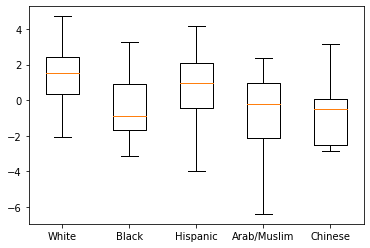

In [45]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

#TODO: code below could possibly be simplified here

white_sentiments = name_sentiments[name_sentiments["group"] == "White"]["sentiment"].tolist()
black_sentiments = name_sentiments[name_sentiments["group"] == "Black"]["sentiment"].tolist()
hispanic_sentiments = name_sentiments[name_sentiments["group"] == "Hispanic"]["sentiment"].tolist()
arab_sentiments = name_sentiments[name_sentiments["group"] == "Arab/Muslim"]["sentiment"].tolist()
chinese_sentiments = name_sentiments[name_sentiments["group"] == "Chinese"]["sentiment"].tolist()

x = name_sentiments["sentiment"].tolist()
y= name_sentiments["group"].tolist()

plt.boxplot([white_sentiments, black_sentiments, hispanic_sentiments, arab_sentiments, chinese_sentiments],
           labels = ["White", "Black", "Hispanic", "Arab/Muslim", "Chinese"])
plt.show()

Looking at the mean sentiment over these different ethnic groups, it's pretty clear that Black names are on average associated with negative sentiment, and so are Arab/Muslim and Chinese names (although not quite as negative).

Why is this happening? Where is the source of bias? It's not from the sentiment lexicon, because it doesn't include any names. The source of bias comes from the pretrained GloVe word embeddings, which are trained using news and web data. As the data encodes biases and stereotypes that reflect our worldview, the sentiment classifier we built ultimately reflects that. It is perhaps impossible to have create perfectly neutral models or datasets, but the point here is **awareness**: that as engineers we should at least be wary of the biases of the data/models we develop, and documenting them in a way such that users/companies that use our systems know their limitations or weaknesses. Although we have yet to explore how to reduce bias, this exercise of building awareness constitutes the first step towards building ethical AI.